In [ ]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root, "src"))

In [ ]:
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from matplotlib.axes import Axes
from monai.losses import DiceLoss
from monai.networks.nets import SegResNet
from torch import Tensor
from tqdm import tqdm

from dataloader import BrainTumourDataModule

## Wrapping SegResNet

The input data must have a shape of (B, N, H, W, D) format
* B - batch size
* N - number of classes
* H - height
* W - width
* D - depth

In [ ]:
class SegResModel(pl.LightningModule):
    def __init__(self, in_channels, out_channels, learning_rate=1e-3):
        super(SegResModel, self).__init__()
        self.model = SegResNet(in_channels=in_channels, out_channels=out_channels)
        self.dice_loss = DiceLoss(softmax=True)
        self.learning_rate = learning_rate

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def training_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        loss, _ = self._common_step(batch, batch_idx)
        return loss

    def _common_step(
        self, batch: Tuple[Tensor, Tensor], batch_idx: int
    ) -> Tuple[Tensor, Tensor]:
        images, labels = batch
        preds = self.forward(images)
        loss = self.dice_loss(preds, labels)
        return loss, preds

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [ ]:
class EnsembleModel(pl.LightningModule):
    def __init__(self, model_list, num_classes):
        super(EnsembleModel, self).__init__()
        self.models = model_list
        self.num_classes = num_classes

    def forward(self, x):
        # Collect predictions from each model in the ensemble
        predictions = [model(x) for model in self.models]
        # Average predictions
        averaged_prediction = torch.mean(torch.stack(predictions), dim=0)
        return averaged_prediction

## Data Module Loading

In [ ]:
image_path = "../data/BrainTumourData/imagesTr/"
label_path = "../data/BrainTumourData/labelsTr/"
data_module = BrainTumourDataModule(
    data_path=image_path, seg_path=label_path, img_dim=(8, 8)
)
data_module.prepare_data()
data_module.setup()

## Training the Model

In [ ]:
# Instantiate each model
segresnet = SegResModel(in_channels=2, out_channels=4)
# model2 = SegResModel(in_channels=2, out_channels=4)

# Train each model separately
trainer = pl.Trainer(max_epochs=1)
trainer.fit(segresnet, data_module)
# trainer.fit(model2, data_module)

# Create the ensemble model using the trained models
# ensemble_model = EnsembleModel([segresnet], num_classes=4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kristof/Melytanulas/medical-image-segmentation/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/kristof/Melytanulas/medical-image-segmentation/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode

Epoch 0: 100%|██████████| 328/328 [01:59<00:00,  2.74it/s, v_num=47]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 328/328 [01:59<00:00,  2.74it/s, v_num=47]


## Running Tests

In [ ]:
segresnet.eval()

image_list: List[Tensor] = []
prediction_list: List[Tensor] = []
label_list: List[Tensor] = []

for images, label in tqdm(data_module.test_dataloader()):
    with torch.no_grad():
        pred: Tensor = segresnet(images)
        image_list.append(images)
        prediction_list.append(pred)
        label_list.append(label)

images: Tensor = torch.cat(image_list, dim=0)
predictions: Tensor = torch.cat(prediction_list, dim=0)
labels: Tensor = torch.cat(label_list, dim=0)

print(f"images shape: {images.shape}")
print(f"predictions shape: {predictions.shape}")
print(f"labels shape: {labels.shape}")

100%|██████████| 59/59 [00:18<00:00,  3.24it/s]

images shape: torch.Size([59, 2, 8, 8, 128])
predictions shape: torch.Size([59, 4, 8, 8, 128])
labels shape: torch.Size([59, 4, 8, 8, 128])


## Prediction Visualization

In [ ]:
def plot_slices(image: Tensor, label: Tensor, pred: Tensor, slice_index: int) -> None:
    image_slice: np.ndarray = image[0, :, :, slice_index].cpu().numpy()
    labels_map: Tensor = torch.argmax(label, dim=0)
    preds_map: Tensor = torch.argmax(pred, dim=0)

    labels_slice: np.ndarray = labels_map[:, :, slice_index].cpu().numpy()
    preds_slice: np.ndarray = preds_map[:, :, slice_index].cpu().numpy()

    axes: Tuple[Axes, Axes, Axes]
    _, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes_orig: Axes = axes[0]
    axes_truth: Axes = axes[1]
    axes_pred: Axes = axes[2]

    axes_orig.imshow(image_slice, cmap="gray")
    axes_orig.set_title("Original MRI Image")
    axes_orig.axis("off")

    axes_truth.imshow(labels_slice, cmap="jet")
    axes_truth.set_title("Ground Truth")
    axes_truth.axis("off")

    axes_pred.imshow(preds_slice, cmap="jet")
    axes_pred.set_title("Predictions")
    axes_pred.axis("off")

    plt.show()

In [ ]:
image = images[0]
print(f"image shape: {image.shape}")

label = labels[0]
print(f"labels shape: {label.shape}")

pred = predictions[0]
print(f"preds shape: {pred.shape}")

image shape: torch.Size([2, 8, 8, 128])
labels shape: torch.Size([4, 8, 8, 128])
preds shape: torch.Size([4, 8, 8, 128])


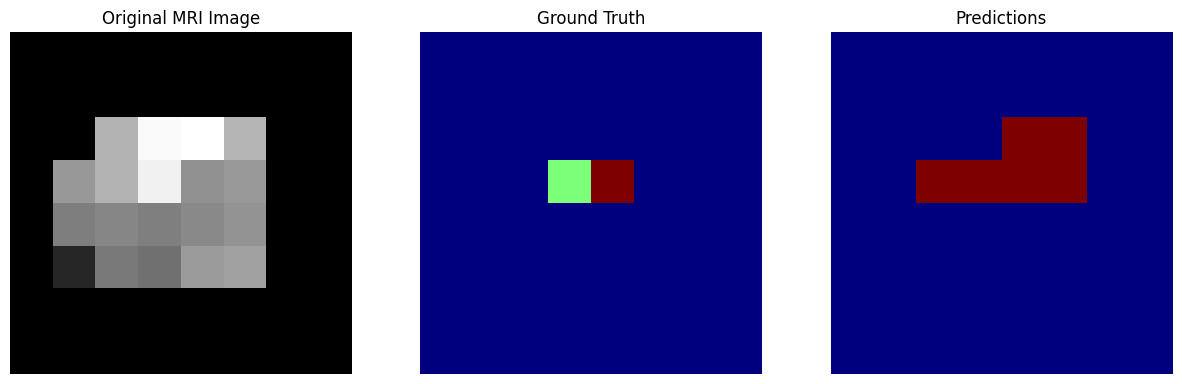

In [13]:
plot_slices(image, label, pred, slice_index=image.shape[3] // 2)